# pytorch workflow
1. Get data ready (turn into tensors)
2. Build or pick a pretrained model
3. Fitting the model to data (training)
4. Make predictions using the fitted model
5. Improve through tuning parameters and hyperparameters through experimentation
6. Save and reload the trained model

In [154]:
import os
import torch
from torch import nn # contains all the building blocks for pytorch
import matplotlib.pyplot as plt
torch.__version__

# visualise training, test data and compares predictions
def plot_predictions(data = X_train, label=y_train, predictions = None):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.scatter(data, label, c="b", s=4, label="Training Data")

    if predictions is not None: ax.plot(data, predictions, c="g", label="Prediction")

    plt.tight_layout()
    plt.legend()
    plt.show()

# 1. Data (preparing and loading)

In [4]:
# create some data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1) # since pytorch requires the data to be in 2D, 2nd dimension is feature

# labels
wt = 0.7
bias = 0.3
y = wt * X + bias # in actual, the output will be known, we need to find the params by finding the pattern

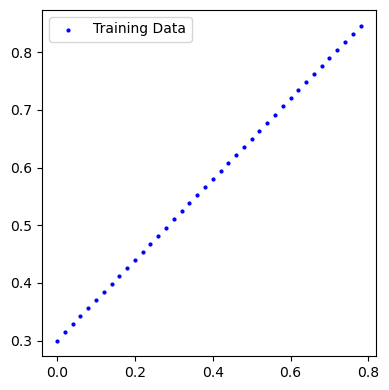

In [30]:
# splitting train, test data. lets do a simple split
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test)

plot_predictions(X_train, y_train)

# 2. Build Model 

## PyTorch building essentials
* torch.nn - contains all the building for computation
* torch.nn.Parameter - what params should our model try and learn
* nn.Module - base calass for all NN modules
* torch.optim - this is where optimisers live, they help in gradient descent

lets use linear regresssion model class. simnple model, therefore we are explicitely setting weights and bias to random values. in practise, we will create as layers (with number of neurons in each layer).

In [133]:
class LinearRegressionModel(nn.Module): # Model that we build should be subclass of this class
    def __init__(self):
        super().__init__()

        self.weights = nn.Parameter(torch.randn(size=(1,), dtype=torch.float32), requires_grad=True) # a tensor that will be part of module parameter
        self.bias = nn.Parameter(torch.randn(size=(1,), dtype=torch.float32), requires_grad=True) # require_grad = True is default
        # require_grad - to track of all the gradients so that it can be used with torch.autograd (pytorch fn to compute the gradient descent)

    def forward(self, x : torch.Tensor) -> torch.Tensor: # expects data as tensor and returns a tensor
        return self.weights * x + self.bias

    

## Checking the contents of our PyTorch model

use `.parameters()`

In [144]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [60]:
# list named parameters
model_0.state_dict(), model_0.state_dict().keys()

(OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))]),
 odict_keys(['weights', 'bias']))

# 3. Fitting the model
Compute the weights as close to the actual created values of `weight = 0.7 and bias = 0.3`. in actual, we wont know this value. we should reduce the cost

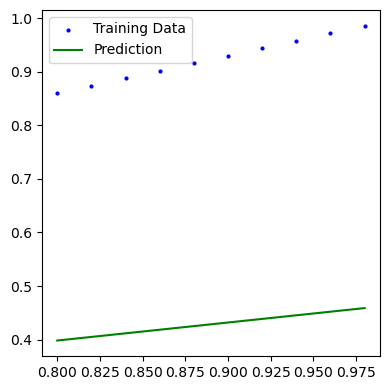

In [68]:
 # error right now

# inference is used to make predictions. therefore, the below function will not keep track fo the gradients. other way to give torch.no_grad()
with torch.inference_mode(): # automatically passes through forward of the model. other word for predictions in pytroch is inference
    y_preds = model_0(X_test)

plot_predictions(X_test, y_test, predictions=y_preds)

Things required to train
* Loss function
* Optimizer - takes into account of the loss of a model and adjusts the parameters (weights and bias) to improve the loss function

In [145]:
# loss function - lets use mean absolute error
loss_fn = nn.L1Loss() # same as torch.mean(torch.abs(y_train - y_preds))

# optimiser - lets use SGD
optim = torch.optim.SGD(params = model_0.parameters(),
                     lr = 0.01)

## building a training loop
Steps involved are,
1. Forward propagation
2. Calculate loss
3. optimizer zero grad
4. back propagation - move backward through the network to calculate the gradients of each param of our model with respect to the loss
5. optimizer step

In [147]:
epochs = 200

epoch_count = []
test_loss_vals = []
train_loss_vals = []

for epoch in range(epochs):

    ### training ###
    model_0.train() # set the model to training. Sets all setting for our training i.e., computing the gradients

    # 1. forward pass
    y_pred = model_0(X_train) # same as forward

    # 2. calculate loss
    loss = loss_fn(y_pred, y_train) # inputs, targets

    # 3. optimizer zero grad
    optim.zero_grad() # if not done, the step (step5) will accumulate, therefore made to 0

    # 4. perform back prop
    loss.backward()

    # step optimizer (SGD)
    optim.step()

    ### testing ###
    model_0.eval() # turns off settings not required for evaluation/testing. eg: dropout, batchnorm etc.

    with torch.inference_mode(): # turn of gradient tracking
        y_pred = model_0(X_test)

    test_loss = loss_fn(y_pred, y_test) # validation score

    if epoch % 10 == 0 or epochs <=10:
        print(f"Epoch: {epoch} | Test loss: {test_loss}")

        epoch_count.append(epoch)
        train_loss_vals.append(loss)
        test_loss_vals.append(test_loss)

Epoch: 0 | Test loss: 0.4675942063331604
Epoch: 10 | Test loss: 0.3328842222690582
Epoch: 20 | Test loss: 0.2069590985774994
Epoch: 30 | Test loss: 0.14023718237876892
Epoch: 40 | Test loss: 0.11182951927185059
Epoch: 50 | Test loss: 0.09809747338294983
Epoch: 60 | Test loss: 0.08776430785655975
Epoch: 70 | Test loss: 0.0794917643070221
Epoch: 80 | Test loss: 0.07190609723329544
Epoch: 90 | Test loss: 0.06363357603549957
Epoch: 100 | Test loss: 0.05536102131009102
Epoch: 110 | Test loss: 0.04777535796165466
Epoch: 120 | Test loss: 0.0395028181374073
Epoch: 130 | Test loss: 0.031230276450514793
Epoch: 140 | Test loss: 0.023644620552659035
Epoch: 150 | Test loss: 0.0153720797970891
Epoch: 160 | Test loss: 0.007099539041519165
Epoch: 170 | Test loss: 0.008447891101241112
Epoch: 180 | Test loss: 0.008447891101241112
Epoch: 190 | Test loss: 0.008447891101241112


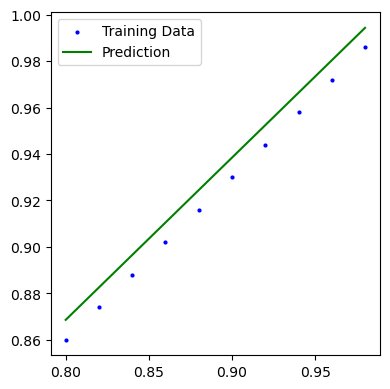

In [137]:
plot_predictions(X_test, y_test, predictions=y_pred)

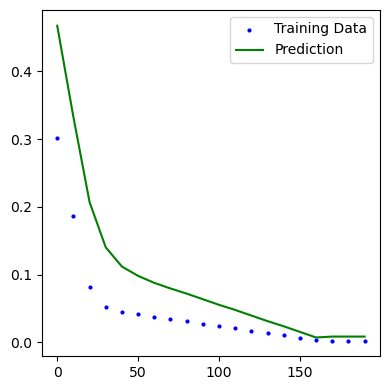

In [153]:
tr_loss = torch.tensor(train_loss_vals).cpu().numpy() # to be able to plot

### loss curve ###
plot_predictions(epoch_count, tr_loss, predictions=test_loss_vals) # training and test loss

# Since they match up, the model is working well

# 6. Saving and loaading a model

* `torch.save()` - save python object in pickle format
* `torch.load()` - load a saved python object
* `torch.nn.Module.load_state_dict()` - load a model's saved state dictionary

In [163]:
# saving our model
from pathlib import Path

# 1. create model directory
model_path = Path("models")
model_path.mkdir(parents=True, exist_ok = True)

# model save path
model_name = "01_pytorch_workflow_model_0.pth" # usual pytorch extension
model_save_path = model_path / model_name

# save model
torch.save(obj=model_0.state_dict(),
           f = model_save_path)

In [168]:
# loading our model state_dict. Done only if inference is being done

# since only state_dict is saved, we will create a model instance and load the parameters
load_model_0 = LinearRegressionModel()

# loading the state_dict
load_model_0.load_state_dict(torch.load(f=model_save_path, weights_only=False, map_location="cpu"))

load_model_0.to("cpu") # to move the entire model to GPU if required

<All keys matched successfully>

In [171]:
load_model_0.state_dict(), model_0.state_dict()

(OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))]),
 OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))]))